In [138]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yahoo_fin.stock_info as si
import yfinance as yf
%config InlineBackend.figure_formats = ['svg']
import statsmodels.api as sm

In [60]:
df = pd.read_csv('snp_500_new.csv')

In [61]:
df = df[['Date', 'Close', 'symbol', 'shortName', 'sector', 'industry', 'country']]
df = df.dropna().reset_index(drop=True)

In [62]:
rest_columns = ['symbol', 'shortName', 'sector', 'industry', 'country']

In [63]:
data = []
for symbol in df['symbol'].unique():
    tmp = df[df['symbol'] == symbol]
    data.append(tmp[rest_columns].iloc[0].values.tolist() + tmp['Close'].values.tolist())

In [64]:
df = pd.DataFrame(data, columns=(rest_columns + df['Date'].unique().tolist()))

In [67]:
start_indx = 300

In [ ]:
def calculate_features(ts):
    features = {
        'min': np.min(ts),
        'max': np.max(ts)
    }
    for i, autocorrelation in enumerate(sm.tsa.acf(ts, nlags=4)):
        if not i:
            continue
        features[f"acf_{i}"] = autocorrelation
    for q in np.linspace(0.1, 0.9, 9):
        features[f"q_{str(round(q, 1)).replace('.', '')}"] = np.quantile(ts, q)
    return features

In [143]:
df.columns[5:]

Index(['2020-05-04 00:00:00', '2020-05-05 00:00:00', '2020-05-06 00:00:00',
       '2020-05-07 00:00:00', '2020-05-08 00:00:00', '2020-05-11 00:00:00',
       '2020-05-12 00:00:00', '2020-05-13 00:00:00', '2020-05-14 00:00:00',
       '2020-05-15 00:00:00',
       ...
       '2022-04-19 00:00:00', '2022-04-20 00:00:00', '2022-04-21 00:00:00',
       '2022-04-22 00:00:00', '2022-04-25 00:00:00', '2022-04-26 00:00:00',
       '2022-04-27 00:00:00', '2022-04-28 00:00:00', '2022-04-29 00:00:00',
       '2022-05-02 00:00:00'],
      dtype='object', length=504)

In [146]:
def get_data(df, stock_names, len_seq=150):
    start_indx = len(df.columns[5:]) - len_seq
    data_normalized = []
    data = []
    for stock_name in stock_names:
        stock_data = df[df['symbol'] == stock_name].iloc[0].values[start_indx:]
        data.append(stock_data)
        data_normalized.append((stock_data - np.mean(stock_data)) / np.std(stock_data))
    data = np.array(data, dtype=np.float32)
    data_normalized = np.array(data_normalized, dtype=np.float32)
    return data, data_normalized

In [147]:
def calculate_features(ts):
    features = {
        'min': np.min(ts),
        'max': np.max(ts)
    }
    for i, autocorrelation in enumerate(sm.tsa.acf(ts, nlags=4)):
        if not i:
            continue
        features[f"acf_{i}"] = autocorrelation
    for q in np.linspace(0.1, 0.9, 9):
        features[f"q_{str(round(q, 1)).replace('.', '')}"] = np.quantile(ts, q)
    return features

In [169]:
def calculate_distance_matrix(data):
    n = data.shape[0]
    mtrx = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(1, n):
            mtrx[i, j] = mtrx[j, i] = np.sqrt(np.sum((data[i] - data[j]) ** 2))
    return mtrx

In [170]:
len_seq = 150
stock_names = ['V', 'MA', 'AAPL', 'MSFT']
data, data_normalized = get_data(df, stock_names, len_seq)
to_df = [calculate_features(stock_normalized) for stock_normalized in data_normalized]
start_indx = len(df.columns[5:]) - len_seq
dates = [date[:10] for date in df.columns[start_indx:].tolist()]

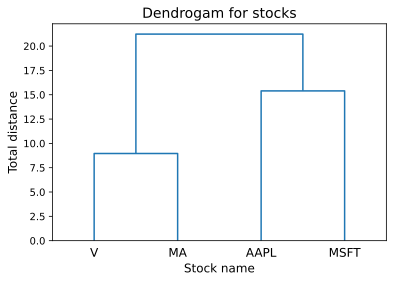

In [286]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(data_normalized, method='ward'), color_threshold=5, labels=stock_names)
plt.xlabel("Stock name", size=12)
plt.ylabel("Total distance", size=12)
plt.title("Dendrogam for stocks", size=14)
plt.show()

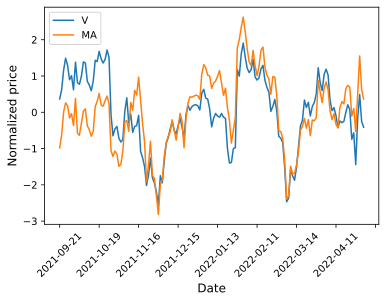

In [177]:
fig, ax = plt.subplots()
for stock_data, stock_name in zip(data_normalized[:2], stock_names[:2]):
    plt.plot(dates, stock_data, label=stock_name)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))

plt.legend(loc='upper left')
plt.xlabel('Date', size=12)
plt.xticks(rotation=45)

plt.ylabel('Normalized price', size=12)
plt.show()

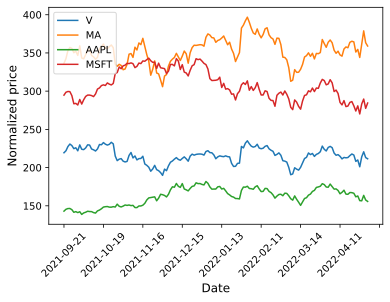

In [171]:
fig, ax = plt.subplots()
for stock_data, stock_name in zip(data, stock_names):
    plt.plot(dates, stock_data, label=stock_name)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))

plt.legend(loc='upper left')
plt.xlabel('Date', size=12)
plt.xticks(rotation=45)

plt.ylabel('Normalized price', size=12)
plt.show()

In [172]:
tmp = pd.DataFrame(to_df).round(2).T
tmp.columns = stock_names
tmp.T

,min,max,acf_1,acf_2,acf_3,acf_4,q_01,q_02,q_03,q_04,q_05,q_06,q_07,q_08,q_09
V,-2.55,1.91,0.90,0.80,0.70,0.61,-1.47,-0.74,-0.41,-0.16,0.02,0.21,0.60,0.98,1.33
MA,-2.82,2.62,0.89,0.76,0.64,0.54,-1.39,-0.73,-0.48,-0.21,0.04,0.28,0.48,0.81,1.24
AAPL,-2.04,1.68,0.96,0.92,0.88,0.85,-1.49,-1.10,-0.50,-0.14,0.17,0.43,0.80,1.02,1.15
MSFT,-1.94,1.77,0.95,0.91,0.87,0.83,-1.27,-0.96,-0.66,-0.44,-0.21,0.12,0.71,1.19,1.43


In [175]:
embd = np.array([np.array(list(d.values())) for d in to_df])
calculate_distance_matrix(embd)

array([[0.       , 0.8165953, 0.8379322, 0.9191511],
       [0.8165953, 0.       , 1.4216566, 1.4653826],
       [0.8379322, 1.4216566, 0.       , 0.7501243],
       [0.9191511, 1.4653826, 0.7501243, 0.       ]], dtype=float32)

In [85]:
calculate_distance_matrix(embd)

array([[0.       , 0.5929901, 1.0964345],
       [0.5929901, 0.       , 1.5554538],
       [1.0964345, 1.5554538, 0.       ]], dtype=float32)

In [84]:
embd = np.array([np.array(list(d.values())) for d in to_df])
embd

array([[-2.41653164,  2.28860519,  0.94306233,  0.88157459,  0.82934776,
         0.77954138, -1.38480313, -0.76297362, -0.51438825, -0.30863282,
         0.00388144,  0.29059782,  0.57576851,  0.80234504,  1.28933466],
       [-2.91651586,  2.3851844 ,  0.90619515,  0.79850229,  0.70611356,
         0.62732053, -1.21760103, -0.71455275, -0.53304027, -0.31251667,
         0.02535613,  0.26273307,  0.47130428,  0.8095905 ,  1.34263067],
       [-1.64423784,  1.94065995,  0.97045467,  0.93922715,  0.91313642,
         0.88812744, -1.17180306, -1.01444077, -0.83271355, -0.64694114,
        -0.07007832,  0.3704304 ,  0.70593658,  1.12335323,  1.36388461]])

## Clustering DTW

In [178]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [214]:
snp500 = df.iloc[:, 5:].values.astype(np.float32)

In [216]:
snp500 = snp500[:, -250:]

In [218]:
snp500 = (snp500 - snp500.mean(axis=1).reshape(-1, 1)) / snp500.std(axis=1).reshape(-1, 1)

In [222]:
symbol_1 = 'AAPL'
symbol_2 = 'MSFT'

In [223]:
i = df[df['symbol'] == symbol_1].index.item()
j = df[df['symbol'] == symbol_2].index.item()

In [241]:
n = snp500.shape[0]
dist_matrix = np.zeros((n, n), dtype=np.float32)

In [242]:
for i in tqdm(range(n)):
    for j in range(1, n):
        try: 
            distance = dtw(snp500[i], snp500[j]).distance
        except:
            distance = np.sqrt(np.sum((snp500[i] - snp500[j]) ** 2))
        dist_matrix[i, j] = dist_matrix[j, i] = distance

100%|██████████| 501/501 [28:46<00:00,  3.45s/it]


In [273]:
from sklearn.cluster import DBSCAN, KMeans

In [251]:
dist_matrix[np.isnan(dist_matrix)] = 2 ** 15

In [ ]:
dbs = KMeans(n_clusters=8, metric='precomputed')
dbs.fit(dist_matrix)

In [270]:
dbs = DBSCAN(eps=45, metric='precomputed', min_samples=2, n_jobs=-1)
dbs.fit(dist_matrix)

DBSCAN(eps=45, metric='precomputed', min_samples=2, n_jobs=-1)

In [271]:
df['cluster'] = dbs.labels_

In [272]:
df.cluster.value_counts()

-1    296
 1    121
 0     67
 8      3
 2      2
 3      2
 4      2
 5      2
 6      2
 7      2
 9      2
Name: cluster, dtype: int64

In [260]:
df[df['cluster'] == 1]

,symbol,shortName,sector,industry,country,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,2020-05-07 00:00:00,2020-05-08 00:00:00,...,2022-04-20 00:00:00,2022-04-21 00:00:00,2022-04-22 00:00:00,2022-04-25 00:00:00,2022-04-26 00:00:00,2022-04-27 00:00:00,2022-04-28 00:00:00,2022-04-29 00:00:00,2022-05-02 00:00:00,cluster
8,ACN,Accenture plc,Technology,Information Technology Services,Ireland,175.546371,177.589996,176.377518,182.958160,184.375992,...,323.670013,322.309998,310.799988,316.820007,303.100006,303.100006,313.839996,300.359985,301.209991,1
239,INTU,Intuit Inc.,Technology,Software—Application,United States,265.732391,272.381165,273.760529,278.652832,278.216187,...,481.950012,465.649994,443.290009,446.929993,421.350006,418.250000,444.579987,418.750000,427.010010,1
252,JCI,Johnson Controls International,Industrials,Engineering & Construction,Ireland,27.522135,27.637896,27.309902,27.512487,28.747271,...,65.099998,65.139999,62.930000,62.709999,60.380001,60.840000,61.500000,59.869999,61.549999,1
259,KEYS,Keysight Technologies Inc.,Technology,Scientific & Technical Instruments,United States,93.489998,96.019997,98.889999,96.989998,100.690002,...,151.220001,149.350006,145.279999,146.960007,141.380005,141.309998,145.179993,140.270004,141.869995,1
396,ROK,"Rockwell Automation, Inc.",Industrials,Specialty Industrial Machinery,United States,181.730209,184.699081,182.977753,184.728104,186.110992,...,272.540009,271.760010,260.529999,261.309998,252.210007,256.790009,263.350006,252.669998,250.039993,1
416,SPGI,S&P Global Inc.,Financial Services,Financial Data & Stock Exchanges,United States,281.312927,290.802582,284.846893,290.969849,293.007599,...,397.250000,390.829987,379.660004,381.220001,375.500000,380.640015,386.549988,376.500000,367.320007,1
500,ZTS,Zoetis Inc.,Healthcare,Drug Manufacturers—Specialty & Generic,United States,126.203392,130.025925,124.470367,123.034431,124.252502,...,187.779999,184.720001,181.949997,180.300003,176.970001,178.470001,181.309998,177.250000,174.669998,1
